In [98]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras import regularizers

from sklearn.model_selection import train_test_split

from lib_classifNN import *
from lib_visu_classif import *

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import os

import pandas as pd
## In this file, we create a neural network with one hidden layer and apply it to the mnist dataset in order to address the classification problem.


In [99]:
path = 'data/FiveCitiePMData'
data = []
for f in os.listdir(path):
    print(f)
    data.append(pd.read_csv(path + '/'+ f))

ShanghaiPM20100101_20151231.csv
ShenyangPM20100101_20151231.csv
GuangzhouPM20100101_20151231.csv
BeijingPM20100101_20151231.csv
ChengduPM20100101_20151231.csv


## Cleaning the dataset 

We will try to make a regression on the PM_US Post values with some continuous and categorical variables in the dataset

In [100]:
beijing = data[3]
print(list(beijing))
np.sum(pd.isna(beijing['PM_Nongzhanguan']))
# removing the 
missing_uspost = [not(e) for e in list(pd.isna(beijing['PM_US Post'], ))]
beijing_cl = beijing[missing_uspost]

features = ['year', 'month', 'day', 'hour', 'season', 'DEWP', 'HUMI', 'PRES', 'TEMP','Iws', 'precipitation', 'Iprec']

['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec']


In [101]:
# check for nas
for e in features:
    print(e, ':', np.sum(pd.isna(beijing_cl[e])), 'nas')

year : 0 nas
month : 0 nas
day : 0 nas
hour : 0 nas
season : 0 nas
DEWP : 5 nas
HUMI : 339 nas
PRES : 339 nas
TEMP : 5 nas
Iws : 5 nas
precipitation : 473 nas
Iprec : 473 nas


In [102]:
# removing the rows for which there are NA
beijing_cl2 = beijing_cl[features + ['PM_US Post' ]].dropna(how = 'any')
X_df = beijing_cl2[features]
y_df = beijing_cl2['PM_US Post']

In [103]:
# checking another time for nas
for e in features:
    print(e, ':', np.sum(pd.isna(X_df[e])), "nas")

print('PM_US Post :', np.sum(pd.isna(y_df)), 'nas')

year : 0 nas
month : 0 nas
day : 0 nas
hour : 0 nas
season : 0 nas
DEWP : 0 nas
HUMI : 0 nas
PRES : 0 nas
TEMP : 0 nas
Iws : 0 nas
precipitation : 0 nas
Iprec : 0 nas
PM_US Post : 0 nas


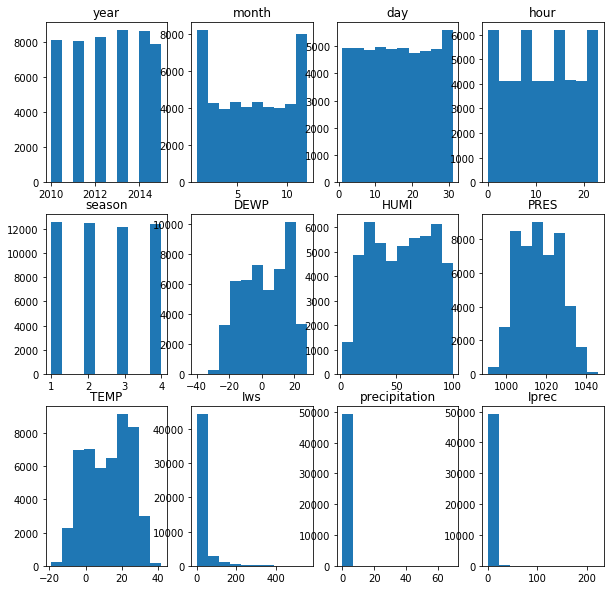

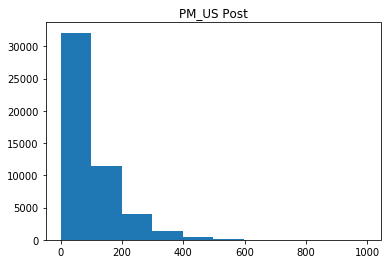

In [104]:
plt.figure(figsize= (10,10))

for i,e in enumerate(list(X_df)):
    plt.subplot(3,4,i+1)
    plt.hist(X_df[e], )
    plt.title(e)
plt.show()

plt.hist(y_df)
plt.title("PM_US Post")
plt.show()

In [105]:
# converting to numpy arrays
X = X_df.values
y = y_df.values

In [179]:
nb_samples = 1000
indices = np.random.shuffle(np.arange(nb_samples))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (39663, 12)
y train shape:  (39663, 1)
X test shape:  (9916, 12)
y test shape:  (9916, 1)


In [180]:
X_train = X_train[:nb_samples]
X_test = X_test[:nb_samples]
y_train = y_train[:nb_samples].reshape((-1, 1))
y_test = y_test[:nb_samples].reshape((-1, 1))
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (1000, 12)
y train shape:  (1000, 1)
X test shape:  (1000, 12)
y test shape:  (1000, 1)


In [181]:
from sklearn.preprocessing import scale

X_train = scale(X_train)
y_train = scale(y_train)
X_test = scale(X_test)
y_test = scale(y_test)


In [182]:
nb_sample_test = 100

X_test = X_test[:nb_sample_test]
y_test = y_test[:nb_sample_test].reshape((-1, 1))

## Using Gaussien Process and gradient descent

In [183]:
import numpy as np
from tqdm import tqdm


def gradient_descent_dropout(x, y, p1, p2, tau, ep=0.0001, max_iter=1000, alpha = 0.0001):
    
    res = []
    converged = False
    iter = 0
    N = x.shape[0] # number of samples
    Q = x.shape[1]
    D = y.shape[1]
    K = 100
    
    
    # initial weight matrices 
    M1 = np.random.normal(0., 1.,(Q, K))
    M2 = np.random.normal(0., 1., (K, D))                                                                                                              
    m = np.random.normal(0., 1., (1,K))
    L_GP_MC = 0
    
    tau = p1/(2*0.01*N)
    
    for _ in tqdm(range(max_iter), desc="main loop"):        
        
        z1v = np.zeros((Q,N))
        z2v = np.zeros((K,N))
        
        for i in range(N):
            z1v[:,i] = np.random.binomial(size=Q, n=1, p=p1)
            z2v[:,i] = np.random.binomial(size=K, n=1, p=p2)        
        
        grad_M1 = np.zeros((Q,K))
        grad_M2 = np.zeros((K,D))
        grad_m = np.zeros((1,K))
        
        L_tmp = L_GP_MC
        L_GP_MC = - p1*np.linalg.norm(M1)**2 - p2*np.linalg.norm(M2)**2 - np.linalg.norm(m)**2
        
        for i in range(N):
            #Bernoulli vectors for dropouts
            z1 = np.diag(z1v[:,i])
            z2 = np.diag(z2v[:,i])
        
            # Computing prediction for the x
            y_pred = (1/K)**(1/2)*np.matmul(np.maximum(0,(np.matmul(x[i],np.matmul(z1,M1))+m)),np.matmul(z2,M2))
            ynew =  y_pred - y[i]
            L_GP_MC -= tau*np.linalg.norm(ynew)**2
            
            partial_Y_tild = 2*(y_pred - y[i])*tau
            
            z1 = np.diag(z1v[:,i])
            z2 = np.diag(z2v[:,i])
            
            # Computing Gradient for each parameters
            
            grad_M2_tmp = np.dot(np.transpose(np.maximum(0, np.dot(np.matrix(x[i]), np.dot(z1, M1)) + m)), np.matrix(partial_Y_tild))
            grad_M2 += np.dot(z2, grad_M2_tmp)
            
            grad_m1 = (np.dot(np.matrix(x[i]), np.dot(z1, M1)) + m > 0)
            grad_m2 = (np.dot(np.matrix(partial_Y_tild), np.transpose(np.dot(z2, M2))))
            grad_m += np.multiply(grad_m1, grad_m2)                               

            grad_M11 = np.transpose(np.matrix(x[i]))
            grad_M12 = np.multiply(np.dot(np.matrix(partial_Y_tild), np.transpose(np.dot(z2, M2))), (np.dot(np.matrix(x[i]), np.dot(z1, M1)) + m > 0))
            grad_M1 += np.dot(z1, np.dot(grad_M11, grad_M12))
            
        
        grad_M1 += p1 * M1
        grad_M2 += p2 * M2
        grad_m += m
        
        # update M
        M1 -= alpha * grad_M1
        M2 -= alpha * grad_M2
        m -= alpha * grad_m
        
        res.append(L_GP_MC)
        
        if(np.abs(L_tmp - L_GP_MC) < ep):
            print("break")
            return res, M1, M2, m
            
    return res, M1, M2, m

class Gaussian_Process:

    def __init__(self, p1=0.8, p2=0.9, hidden_units=100):
        self.p1=p1
        self.p2=p2
        self.K=hidden_units

        self.M1 = 0
        self.M2 = 0
        self.m = 0

    def fit(self, X_train, Y_train, p1=0.8, p2=0.9, tau=0.1, ep=0.0001, max_iter=1000, alpha = 0.0005, verbose=False):

        history_loss, self.M1, self.M2, self.m = gradient_descent_dropout(X_train, Y_train, p1, p2, 0.1, ep=1e-7, max_iter=max_iter, alpha = alpha)
        return history_loss
        
    def predict(self, X_test, p1=0.8, p2=0.9):

        Q = self.M1.shape[0]
        K = self.K
        N = X_test.shape[0] # number of samples
        if(X_test.shape[1]!= Q):
            print("ERREUR DE DIM")


        Y_predict = []
        for i in range(N):
            z1 = np.diag(np.random.binomial(size=Q, n=1, p=p1))
            z2 = np.diag(np.random.binomial(size=K, n=1, p=p2))

            # Computing prediction for the x
            y_pred = (1/K)**(1/2)*np.matmul(np.maximum(0,(np.matmul(X_test[i],np.matmul(z1,self.M1))+self.m)),
                np.matmul(z2,self.M2))
            Y_predict.append(y_pred)
        return Y_predict
    
    def accuracy(self, X_test, Y_test, p1 = 0.8, p2=0.9):
        Y_predict = self.predict(X_test, p1, p2)
        acc = (np.linalg.norm(Y_predict - Y_test)**2)/(np.linalg.norm(Y_test)**2)
        return acc

    def plot_acc(self, X_test, Y_test, p1=0.8, p2=0.9):
        Y_predict = self.predict(X_test, p1, p2)
        plt.plot(Y_predict, Y_test)
        plt.show()



main loop:   2%|▏         | 8/500 [00:02<02:05,  3.92it/s]/Users/Erwan1/anaconda/envs/hackathon/lib/python3.4/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
/Users/Erwan1/anaconda/envs/hackathon/lib/python3.4/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in multiply
main loop:   2%|▏         | 9/500 [00:02<02:06,  3.88it/s]/Users/Erwan1/anaconda/envs/hackathon/lib/python3.4/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in greater
/Users/Erwan1/anaconda/envs/hackathon/lib/python3.4/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in greater
main loop: 100%|██████████| 500/500 [02:13<00:00,  3.75it/s]


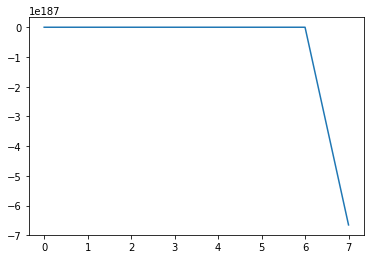

In [188]:
GP = Gaussian_Process()
pl = GP.fit(X_train, y_train, p1=0.8, p2=0.9,verbose=True, max_iter=500, alpha=0.002)

plt.plot(pl)
plt.show()

In [186]:
GP.accuracy(X_test, y_test, p1=0.7, p2=0.9)

126.14322123529446

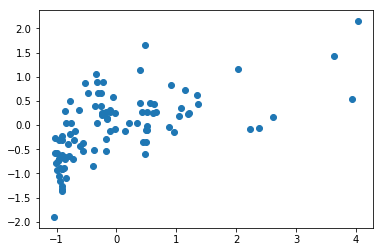

In [187]:
Y_pred = GP.predict(X_test, p1=1., p2=1.)
plt.scatter(y_test[:,0], np.array(Y_pred)[:,0,0])
plt.show()
